### First Things First

This notebook is to demonstrate how to create a minimap from an area.

Notes: 

1. A full NWN:EE install is required to run this notebook, the docker distro won't work because it strips textures.

In [1]:
import rollnw
from rollnw import kernel as nwk
from PIL import Image
from IPython.display import display
import configparser
import  sys

nwk.start()
mod = nwk.load_module("../tests/test_data/user/modules/DockerDemo.mod")


### Loading an Area 

Once a module is loaded getting areas is super simple, they're all instantiated like the game, creatures, and all.  *Not* like the toolset that instantiates an area on demand.

In [2]:
area = mod.get_area(0)
print(f"Area Size: {area.width}x{area.height}")
print(f"Tile Count: {len(area.tiles)}")

Area Size: 4x4
Tile Count: 16


### The Functions

``chunks`` is a helper that creates a 2-dimensional list out of a 1-dimensional list by some value ``n``

``texture_to_image`` just a simple wrapper to create PIL Images from rollnw Images

``area_to_map`` creates the minimap

In [9]:
def chunks(l, n):
    """Cut a slicable object into N length pieces.
    """
    return [l[i:i + n] for i in range(0, len(l), n)]


def texture_to_image(resref: str):
    image = nwk.resman().texture(resref)
    if image.channels() == 4:
        return Image.frombytes("RGBA", (image.width(), image.height()), image.data())
    else:
        return Image.frombytes("RGB", (image.width(), image.height()), image.data())


def area_to_map(area: rollnw.Area):
    scale    = 1
    minimum  = 32
    texture_map = {}
    config = configparser.ConfigParser()
    textures = []
    texture_size  = sys.maxsize

    set_file = rollnw.kernel.resman().demand(area.tileset_resref + ".set")
    config.read_string(set_file.bytes.decode())

    for tile in area.tiles:
        texture_name = config.get(f'TILE{tile.id}', 'ImageMap2D').lower()

        if not texture_name in texture_map:
            texture_map[texture_name] = texture_to_image(texture_name)

        image = texture_map[texture_name]

        # I chose here to scale all the minimap images to the smallest size so if one is 8x8
        # they will all be scaled to 8x8.
        texture_size = min(texture_size, image.width)
        textures.append((image, tile.orientation))

    # Note: The tile list begins in the bottom left corner  so I'm going to reverse so that it
    # starts in the top left and draw down rather than up.
    textures = chunks(textures, area.width)[::-1]

    # minimum minimap tile size 16x16, just so some of the smaller 8x8s are a little larger.
    texture_size = max(minimum, texture_size * scale)

    image = Image.new('RGBA', (area.width * texture_size,
                                 area.height * texture_size))

    for h in range(area.height):
        for w in range(area.width):
            im, rot = textures[h][w]
            location = (w * texture_size, h * texture_size)

            if im.size[0] != texture_size:
                im = im.resize((texture_size, texture_size))

            # Note: tile orientation is 0, 1, 2, 3 corresponding to 0, 90, 180, 240, etc
            # degrees of rotation, i,e tile.orientation * 90 == rotation in degrees.
            image.paste(im.rotate(rot*90), location)

    return image


### Finally

Pick an area, make the minimap, and display the image. (This might need to be flipped.)

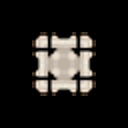

In [10]:
image = area_to_map(mod.get_area(0))
display(image)